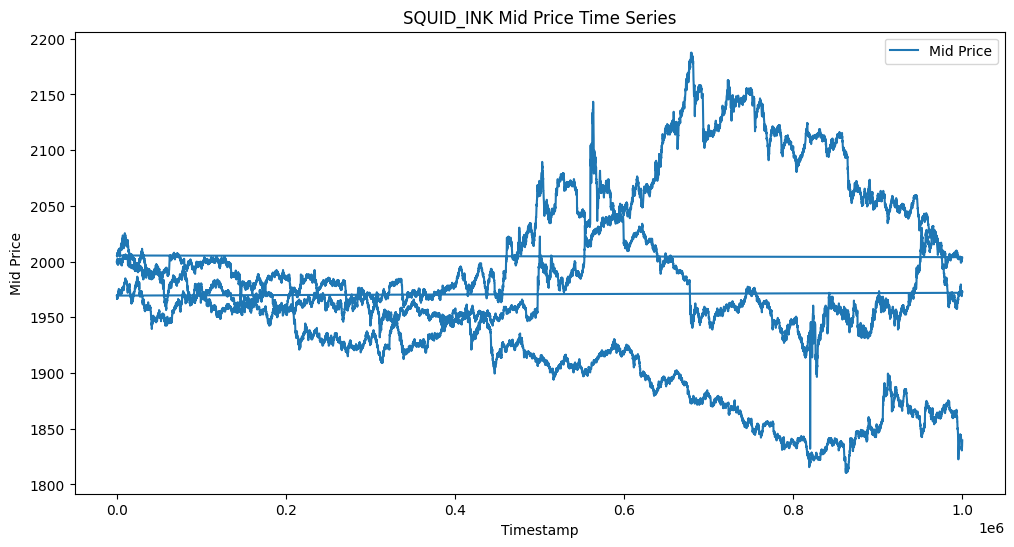

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the price data for SQUID_INK (modify file paths as needed)
price_files = [
    "../data/prices_round_1_day_-1.csv",
    "../data/prices_round_1_day_-2.csv",
    "../data/prices_round_1_day_0.csv"
]

dfs = []
for file in price_files:
    df = pd.read_csv(file, delimiter=';')
    df = df[df['product'] == "SQUID_INK"]
    # Convert timestamp and mid_price columns to numeric
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['mid_price'] = pd.to_numeric(df['mid_price'], errors='coerce')
    dfs.append(df)

prices_df = pd.concat(dfs, ignore_index=True)
prices_df = prices_df.sort_values(by=["day", "timestamp"])
prices_df = prices_df.dropna(subset=['mid_price'])

plt.figure(figsize=(12, 6))
plt.plot(prices_df['timestamp'], prices_df['mid_price'], label="Mid Price")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.title("SQUID_INK Mid Price Time Series")
plt.legend()
plt.show()


count    29999.000000
mean        -0.000002
std          0.000912
min         -0.053963
25%         -0.000502
50%          0.000000
75%          0.000503
max          0.039301
Name: return, dtype: float64


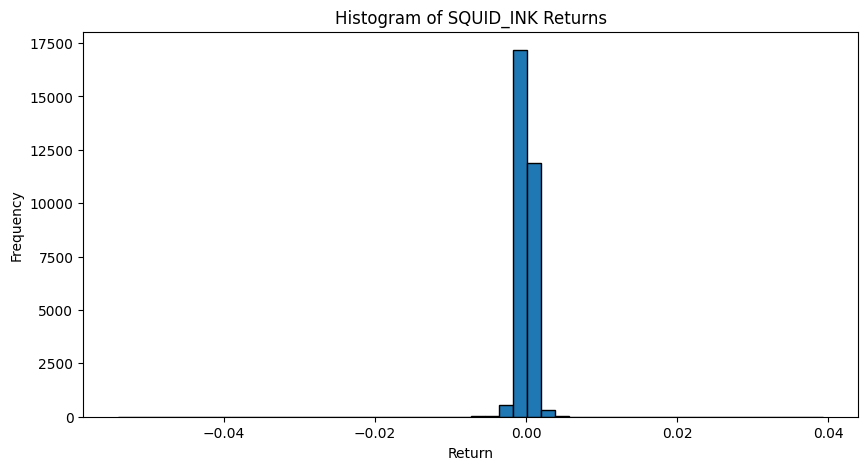

In [8]:
import numpy as np

# Calculate returns as percentage change.
prices_df['return'] = prices_df['mid_price'].pct_change()
print(prices_df['return'].describe())

plt.figure(figsize=(10, 5))
plt.hist(prices_df['return'].dropna(), bins=50, edgecolor='k')
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.title("Histogram of SQUID_INK Returns")
plt.show()


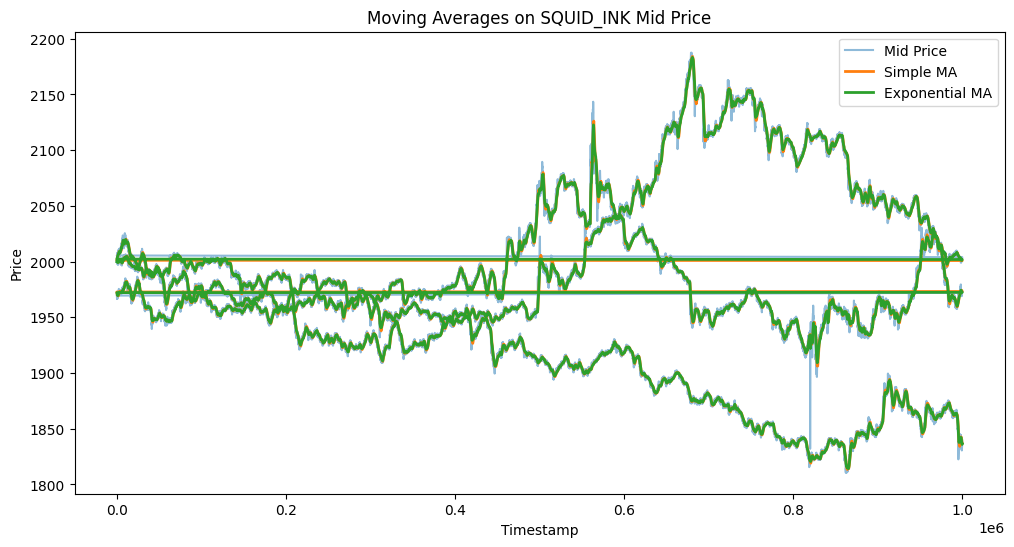

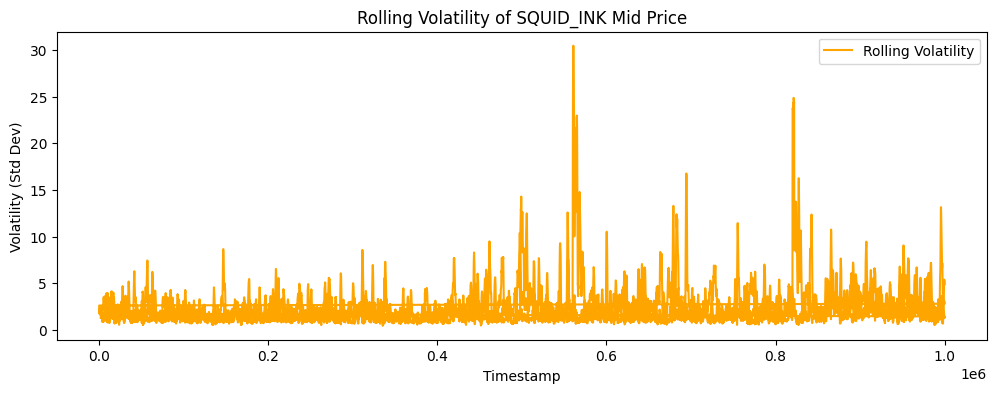

In [9]:
window = 20  # for example a 20-timestep window
prices_df['SMA'] = prices_df['mid_price'].rolling(window=window).mean()
prices_df['EMA'] = prices_df['mid_price'].ewm(span=window, adjust=False).mean()
prices_df['volatility'] = prices_df['mid_price'].rolling(window=window).std()

plt.figure(figsize=(12, 6))
plt.plot(prices_df['timestamp'], prices_df['mid_price'], label="Mid Price", alpha=0.5)
plt.plot(prices_df['timestamp'], prices_df['SMA'], label="Simple MA", linewidth=2)
plt.plot(prices_df['timestamp'], prices_df['EMA'], label="Exponential MA", linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Moving Averages on SQUID_INK Mid Price")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(prices_df['timestamp'], prices_df['volatility'], label="Rolling Volatility", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("Volatility (Std Dev)")
plt.title("Rolling Volatility of SQUID_INK Mid Price")
plt.legend()
plt.show()


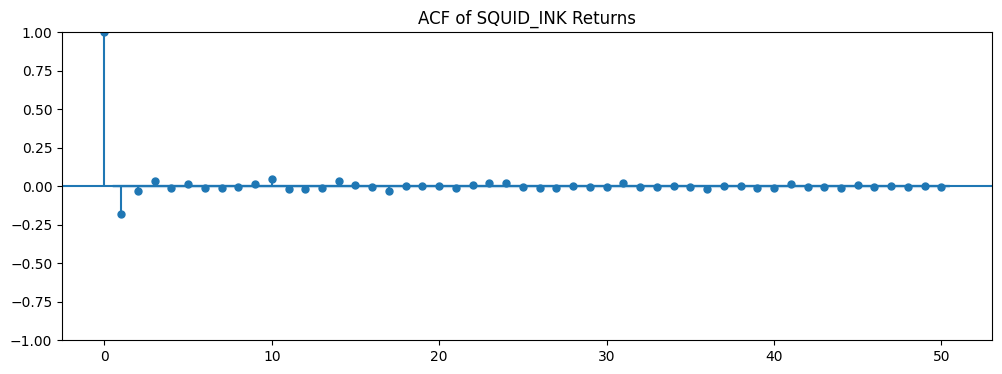

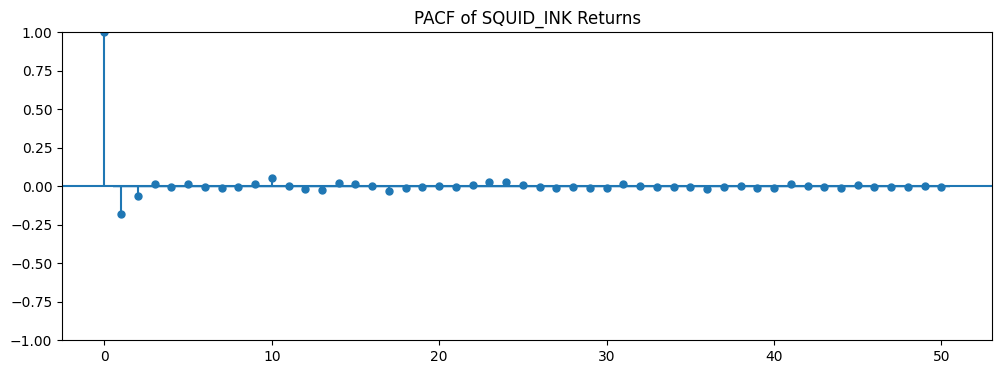

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

returns = prices_df['return'].dropna()

plt.figure(figsize=(12, 4))
plot_acf(returns, lags=50, ax=plt.gca())
plt.title("ACF of SQUID_INK Returns")
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(returns, lags=50, ax=plt.gca())
plt.title("PACF of SQUID_INK Returns")
plt.show()


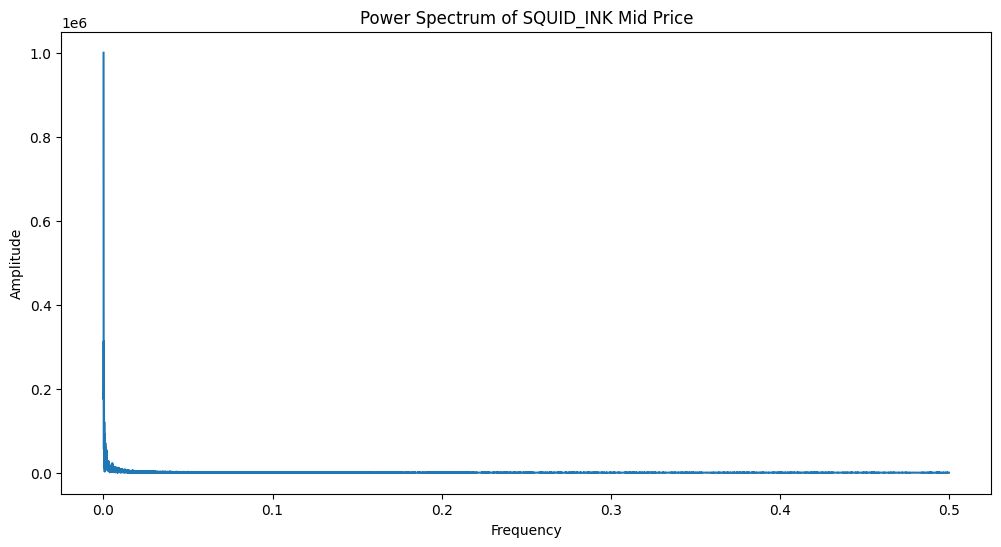

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Remove mean for Fourier analysis.
mid_prices = prices_df['mid_price'].values
mid_prices_detrended = mid_prices - np.mean(mid_prices)
fft_vals = np.fft.fft(mid_prices_detrended)
fft_freq = np.fft.fftfreq(len(fft_vals))

# Consider only the positive frequencies.
mask = fft_freq > 0
plt.figure(figsize=(12, 6))
plt.plot(fft_freq[mask], np.abs(fft_vals)[mask])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Power Spectrum of SQUID_INK Mid Price")
plt.show()


Total SQUID_INK data points: 30000
                               SARIMAX Results                                
Dep. Variable:              mid_price   No. Observations:                30000
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -59712.334
Date:                Thu, 10 Apr 2025   AIC                         119430.668
Time:                        02:48:11   BIC                         119455.595
Sample:                             0   HQIC                        119438.666
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0746      0.005     14.464      0.000       0.064       0.085
ma.L1         -0.2554      0.005    -48.700      0.000      -0.266      -0.245
sigma2         3.

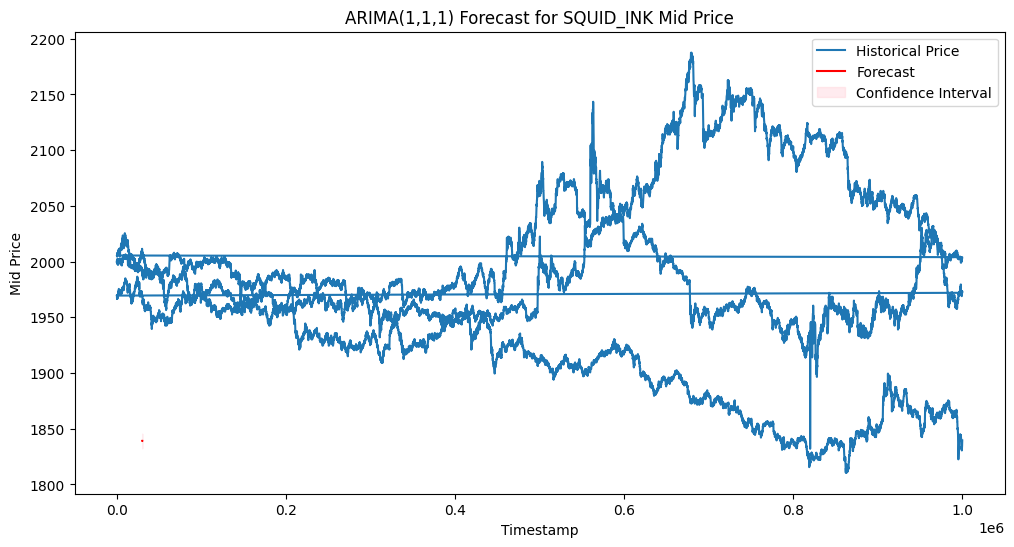

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Ignore harmless warnings from statsmodels.
warnings.filterwarnings("ignore")

# -----------------------------
# STEP 1: Data Loading & Preprocessing
# -----------------------------
# List your price CSV files.
price_files = [
    "../data/prices_round_1_day_-1.csv",
    "../data/prices_round_1_day_-2.csv",
    "../data/prices_round_1_day_0.csv"
]

dfs = []
for file in price_files:
    df = pd.read_csv(file, delimiter=';')
    # Filter to keep only SQUID_INK data.
    df = df[df['product'] == "SQUID_INK"]
    # Ensure timestamp and mid_price are numeric.
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['mid_price'] = pd.to_numeric(df['mid_price'], errors='coerce')
    dfs.append(df)

# Concatenate and sort by timestamp.
prices_df = pd.concat(dfs, ignore_index=True)
prices_df = prices_df.sort_values(by=["day", "timestamp"])
prices_df.dropna(subset=['mid_price'], inplace=True)
prices_df.reset_index(drop=True, inplace=True)

print("Total SQUID_INK data points:", len(prices_df))

# -----------------------------
# STEP 2: Prepare Time Series Data
# -----------------------------
# We use the mid_price as the series to model.
ts = prices_df['mid_price']
# Optionally, convert the timestamp to a datetime index if available.
# For illustration, we can treat the "timestamp" as an increasing integer index.
ts.index = pd.Index(prices_df['timestamp'])

# -----------------------------
# STEP 3: Train an ARIMA Model
# -----------------------------
# For this example, we choose an ARIMA(1,1,1) model.
# The order (p, d, q) can be tuned based on your data.
model_order = (1, 1, 1)
model = ARIMA(ts, order=model_order)
model_fit = model.fit()

print(model_fit.summary())

# -----------------------------
# STEP 4: Forecast Future Values
# -----------------------------
# Let's forecast the next 50 time steps.
forecast_steps = 5
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# -----------------------------
# STEP 5: Visualize the Results
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Historical Price")
plt.plot(forecast_mean.index, forecast_mean, color="red", label="Forecast")
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color="pink", alpha=0.3, label="Confidence Interval")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.title("ARIMA(1,1,1) Forecast for SQUID_INK Mid Price")
plt.legend()
plt.show()
